# Mandatory Challenge
## Context
You work in the data analysis team of a very important company. On Monday, the company shares some good news with you: you just got hired by a major retail company! So, let's get prepared for a huge amount of work!

Then you get to work with your team and define the following tasks to perform:   
1. You need to start your analysis using data from the past.  
2. You need to define a process that takes your daily data as an input and integrates it.  

You are in charge of the second part, so you are provided with a sample file that you will have to read daily. To complete you task, you need the following aggregates:
* One aggregate per store that adds up the rest of the values.
* One aggregate per item that adds up the rest of the values.

You can import the dataset `retail_sales` from Ironhack's database. 

## Your task
Therefore, your process will consist of the following steps:
1. Read the sample file that a daily process will save in your folder. 
2. Clean up the data.
3. Create the aggregates.
4. Write three tables in your local database: 
    - A table for the cleaned data.
    - A table for the aggregate per store.
    - A table for the aggregate per item.

## Instructions
* Read the csv you can find in Ironhack's database.
* Clean the data and create the aggregates as you consider.
* Create the tables in your local database.
* Populate them with your process.

## Import libraries 

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt

driver = 'mysql+pymysql:'
user = 'ironhacker_read'
password = 'ir0nhack3r'
ip = '35.239.232.23'
database = 'retail_sales'

## Create connection string and download databases

In [2]:
connection_string = f'{driver}//{user}:{password}@{ip}/{database}'

In [3]:
engine = create_engine(connection_string)
engine.table_names() # if we want to see the columns that we have in our dataset 

['raw_sales', 'sales_by_item', 'sales_by_item_index', 'sales_by_shop']

In [4]:

query = """
        SELECT * FROM raw_sales;
"""


query2 = """
        SELECT * FROM sales_by_item;
"""

query3 = """
        SELECT * FROM sales_by_item_index;
"""

query4 = """
        SELECT * FROM sales_by_shop;
"""

In [5]:
raw_sales = pd.read_sql(query, engine)
sales_by_item = pd.read_sql(query2, engine)
sales_by_item_index = pd.read_sql(query3, engine)
sales_by_shop = pd.read_sql(query4, engine)

In [6]:
raw_sales.to_csv("../raw_sales.csv", sep = ",")
sales_by_item.to_csv("../sales_by_item.csv", sep = ",")
sales_by_shop.to_csv("../sales_by_shop.csv", sep = ",")
sales_by_item_index.to_csv("../sales_by_item_index.csv", sep = ",")

In [7]:
sales_by_shop.head()

,shop_id,shop_earnings,total_items_sold,date
0,2,33023.5,27.0,03/09/2019
1,3,22481.0,11.0,03/09/2019
2,4,9787.0,13.0,03/09/2019
3,5,11046.0,15.0,03/09/2019
4,6,38784.0,50.0,03/09/2019


## Raw sales data

In [8]:
raw_sales.head()

,date,shop_id,item_id,item_price,item_cnt_day
0,2015-01-04,29,1469,1199.0,1.0
1,2015-01-04,28,21364,479.0,1.0
2,2015-01-04,28,21365,999.0,2.0
3,2015-01-04,28,22104,249.0,2.0
4,2015-01-04,28,22091,179.0,1.0


In [9]:
raw_sales.sort_values(by='item_price').head()

,date,shop_id,item_id,item_price,item_cnt_day
2977,2015-01-04,10,20949,3.0,2.0
1462,2015-01-04,10,20949,3.0,2.0
4492,2015-01-04,10,20949,3.0,2.0
1422,2015-01-04,18,20949,5.0,2.0
2343,2015-01-04,52,20949,5.0,2.0


In [10]:
raw_sales.head()

,date,shop_id,item_id,item_price,item_cnt_day
0,2015-01-04,29,1469,1199.0,1.0
1,2015-01-04,28,21364,479.0,1.0
2,2015-01-04,28,21365,999.0,2.0
3,2015-01-04,28,22104,249.0,2.0
4,2015-01-04,28,22091,179.0,1.0


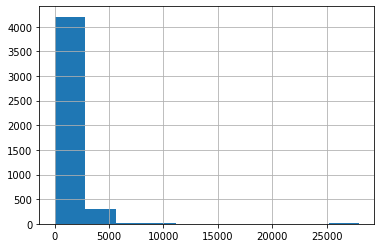

In [11]:
# We want to draw an histogram to see what's the distribution of the prices along the dataset. 
# This will help us to analyze whether there are anormal values in our dataset. 

raw_sales['item_price'].hist()
plt.show()

In [13]:
# assume all values outside of UQ + (IQR*1.5) are outliers and should be removed
# upper boundry = 2606

raw_sales_clean = raw_sales[raw_sales["item_price"]<2606]
print(raw_sales, raw_sales_clean.shape)

           date  shop_id  item_id  item_price  item_cnt_day
0    2015-01-04       29     1469      1199.0           1.0
1    2015-01-04       28    21364       479.0           1.0
2    2015-01-04       28    21365       999.0           2.0
3    2015-01-04       28    22104       249.0           2.0
4    2015-01-04       28    22091       179.0           1.0
5    2015-01-04       28    21842       149.0           1.0
6    2015-01-04       28    21881       299.0           1.0
7    2015-01-04       29     6930      2199.0           1.0
8    2015-01-04       29    10515       169.0           1.0
9    2015-01-04       29     8624       149.0           1.0
10   2015-01-04       29     4178      1590.0           1.0
11   2015-01-04       29     5643      2990.0           1.0
12   2015-01-04       29     5823      2799.0           1.0
13   2015-01-04       29     5037      2599.0           1.0
14   2015-01-04       29     5013       698.0           1.0
15   2015-01-04       29     5822      1

In [14]:
raw_sales_clean.head()

,date,shop_id,item_id,item_price,item_cnt_day
0,2015-01-04,29,1469,1199.0,1.0
1,2015-01-04,28,21364,479.0,1.0
2,2015-01-04,28,21365,999.0,2.0
3,2015-01-04,28,22104,249.0,2.0
4,2015-01-04,28,22091,179.0,1.0


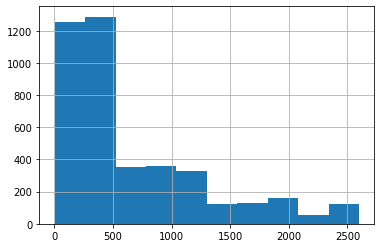

In [15]:
raw_sales_clean['item_price'].hist()
plt.show()

In [16]:
raw_sales_clean.describe()

,shop_id,item_id,item_price,item_cnt_day
count,4176.00000,4176.000000,4176.000000,4176.000000
mean,34.35273,11543.504310,662.587984,1.105603
std,16.54446,6463.005777,623.806902,0.546393
min,2.00000,30.000000,3.000000,-1.000000
25%,22.00000,5759.750000,199.000000,1.000000
50%,31.00000,11901.500000,399.000000,1.000000
75%,51.00000,16922.250000,999.000000,1.000000
max,59.00000,22162.000000,2599.000000,10.000000


In [17]:
# we are finding the negative value on item_cnt_day 

raw_sales_clean.sort_values(by='item_cnt_day').head()

#we consider that negative values are devolutions to the shop. 

,date,shop_id,item_id,item_price,item_cnt_day
3931,2015-01-04,44,8095,499.00,-1.0
1161,2015-01-04,42,1878,2599.00,-1.0
3855,2015-01-04,52,16677,332.67,-1.0
4446,2015-01-04,19,2690,1598.00,-1.0
2676,2015-01-04,42,1878,2599.00,-1.0


In [36]:
raw_sales_clean.to_csv('../raw_sales_clean.csv')

## Sales by item:  Data Cleaning and aggregating

In [ ]:
sales_by_item.head()

In [ ]:
sales_by_item_index.head()

## Sales by shop: Data Cleaning and aggregating

First of all, we take a look at the types of each column. Then, we can see that we should change the date into a datetime index

In [22]:
sales_by_shop.info()
sales_by_shop = sales_by_shop.astype({"date": "datetime64[ns]"})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 4 columns):
shop_id             90 non-null int64
shop_earnings       90 non-null float64
total_items_sold    90 non-null float64
date                90 non-null object
dtypes: float64(2), int64(1), object(1)
memory usage: 2.9+ KB


In [24]:
#Check in describe which is the structure of the elements and the range of each value. 
sales_by_shop.describe()

,shop_id,shop_earnings,total_items_sold
count,90.000000,90.000000,90.000000
mean,32.311111,34733.432741,37.155556
std,17.621262,25449.615414,28.852165
min,2.000000,3095.000000,6.000000
25%,18.000000,15703.000000,20.000000
50%,34.000000,28579.000000,26.000000
75%,48.000000,45106.000000,50.000000
max,59.000000,109288.000000,134.000000


In [25]:
sales_by_shop_agg = sales_by_shop.groupby(['shop_id']).sum()

In [27]:
sales_by_shop_agg.head() ## total sales up to the date this database is updated. 

,shop_earnings,total_items_sold
shop_id,,
2,66047.0,54.0
3,44962.0,22.0
4,19574.0,26.0
5,22092.0,30.0
6,77568.0,100.0


In [28]:
sales_by_shop_agg.to_csv('../sales_by_shop_agg.csv')

### Sales by item (aggregated)

In [29]:
sales_by_item.info()
sales_by_item = sales_by_item.astype({"date": "datetime64[ns]"})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2955 entries, 0 to 2954
Data columns (total 4 columns):
item_id             2955 non-null int64
item_earnings       2955 non-null float64
total_items_sold    2955 non-null float64
date                2955 non-null object
dtypes: float64(2), int64(1), object(1)
memory usage: 92.4+ KB


In [30]:
#Check in describe which is the structure of the elements and the range of each value. 
sales_by_item.describe()

,item_id,item_earnings,total_items_sold
count,2955.000000,2955.000000,2955.000000
mean,10978.312690,1586.806572,1.697462
std,6280.104144,4397.621492,2.104701
min,30.000000,25.000000,-1.000000
25%,5240.000000,229.000000,1.000000
50%,11222.000000,499.000000,1.000000
75%,16083.000000,1399.000000,2.000000
max,22162.000000,80970.000000,31.000000


In [33]:
sales_by_item_agg = sales_by_item.groupby(['item_id']).sum()

In [34]:
sales_by_item_agg.head() ## total sales by ITEM up to the date this database is updated. 

,item_earnings,total_items_sold
item_id,,
30,507.0,3.0
31,1089.0,3.0
32,447.0,3.0
42,897.0,3.0
59,747.0,3.0


In [41]:
sales_by_item_agg.to_csv('../sales_by_item_agg.csv')

### csv export to local database

In [37]:
# Workbench Databench 
driver = 'mysql+pymysql'
user = 'root'
password = 'iMc91linux'
ip = 'localhost'
database = 'lab_df_calc'

In [38]:
connection_string = f'{driver}://{user}:{password}@{ip}/{database}'

In [39]:
engine = create_engine(connection_string)

In [ ]:
raw_sales_clean.to_sql('raw_sales_clean', engine)

In [44]:
sales_by_shop_agg.to_sql('sales_by_shop_agg', engine)
sales_by_item_agg.to_sql('sales_by_item_agg', engine)
#station_info.to_sql('station_info', engine)